In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Define file paths
file_paths = [
    'HIST_EE_2013.csv', 'HIST_EE_2014.csv', 'HIST_EE_2015.csv',
    'HIST_LT_2013.csv', 'HIST_LT_2014.csv', 'HIST_LT_2015.csv',
    'HIST_LV_2013.csv', 'HIST_LV_2014.csv', 'HIST_LV_2015.csv'
]

# Load each CSV file into a DataFrame with semicolon separator
data_frames = [pd.read_csv(file, delimiter=';', names=['date', 'time', 'customer_id', 'product_id', 'boxes_ordered', 'boxes_delivered']) for file in file_paths]
combined_data = pd.concat(data_frames, ignore_index=True)

# Display combined data
combined_data.head()


,date,time,customer_id,product_id,boxes_ordered,boxes_delivered
0,04.01.2013,9:30,S250,510643,1,1
1,04.01.2013,9:30,S250,510745,1,1
2,04.01.2013,9:30,S250,7005584,1,1
3,04.01.2013,9:30,S250,7016899,1,1
4,04.01.2013,9:30,S250,7022473,1,1


In [20]:
# Ensure 'openpyxl' is installed
!pip install openpyxl

import pandas as pd
from datetime import datetime

# Load brand information
brands_info = pd.read_excel('Articles with Brands.xlsx', names=['product_id', 'brand'])
print("Brands Info:")
print(brands_info.head())

# Assuming combined_data is already loaded with your historical data
# For example, you can combine the CSV files as follows:
file_paths = [
    'HIST_EE_2013.csv', 'HIST_EE_2014.csv', 'HIST_EE_2015.csv',
    'HIST_LT_2013.csv', 'HIST_LT_2014.csv', 'HIST_LT_2015.csv',
    'HIST_LV_2013.csv', 'HIST_LV_2014.csv', 'HIST_LV_2015.csv'
]

# Load each CSV file into a DataFrame with semicolon separator
data_frames = [pd.read_csv(file, delimiter=';', names=['date', 'time', 'customer_id', 'product_id', 'boxes_ordered', 'boxes_delivered']) for file in file_paths]
combined_data = pd.concat(data_frames, ignore_index=True)

print("Combined Data:")
print(combined_data.head())

# Merge historical data with brand information
data = pd.merge(combined_data, brands_info, left_on='product_id', right_on='product_id')

# Define a custom function to parse datetime
def parse_datetime(row):
    for fmt in ('%d.%m.%Y %H:%M:%S', '%d.%m.%Y %H:%M'):
        try:
            return datetime.strptime(row['date'] + ' ' + row['time'], fmt)
        except ValueError:
            pass
    raise ValueError(f"no valid date format found for {row['date']} {row['time']}")

# Apply the custom function to parse datetime
data['datetime'] = data.apply(parse_datetime, axis=1)

# Drop the original date and time columns
data.drop(columns=['date', 'time'], inplace=True)

# Display the final dataframe with the datetime column
print("Final Data:")
print(data.head())


Brands Info:
   product_id brand
0      400587     A
1      402094     A
2      402304     A
3      402305     A
4      402308     A
Combined Data:
         date  time customer_id  product_id  boxes_ordered  boxes_delivered
0  04.01.2013  9:30        S250      510643              1                1
1  04.01.2013  9:30        S250      510745              1                1
2  04.01.2013  9:30        S250     7005584              1                1
3  04.01.2013  9:30        S250     7016899              1                1
4  04.01.2013  9:30        S250     7022473              1                1
Final Data:
  customer_id  product_id  boxes_ordered  boxes_delivered brand  \
0        S250      510643              1                1     A   
1        S245      510643              1                1     A   
2        S220      510643              1                1     A   
3        S208      510643              1                1     A   
4        S238      510643              1         

In [21]:
switching_dates = {
    'A': '2014-03-01',
    'B': '2014-01-01',
    'C': '2014-09-01',
    'D': '2014-07-01',
    'E': '2014-10-01'
}


In [22]:
def calculate_csl(data, brand, switch_date):
    switch_date = pd.to_datetime(switch_date)
    pre_period = data[(data['brand'] == brand) & (data['datetime'] < switch_date) & (data['datetime'] >= switch_date - pd.DateOffset(years=1))]
    post_period = data[(data['brand'] == brand) & (data['datetime'] >= switch_date) & (data['datetime'] < switch_date + pd.DateOffset(years=1))]
    
    pre_csl = (pre_period['boxes_delivered'].sum() / pre_period['boxes_ordered'].sum()) * 100
    post_csl = (post_period['boxes_delivered'].sum() / post_period['boxes_ordered'].sum()) * 100
    
    return pre_csl, post_csl

csl_results = {}
for brand, switch_date in switching_dates.items():
    pre_csl, post_csl = calculate_csl(data, brand, switch_date)
    csl_results[brand] = {'pre_csl': pre_csl, 'post_csl': post_csl}
    
csl_results_df = pd.DataFrame(csl_results).transpose()
csl_results_df


,pre_csl,post_csl
A,93.480947,82.237380
B,98.239998,95.181403
C,97.796532,92.652784
D,94.361759,77.758585
E,91.083539,87.128454


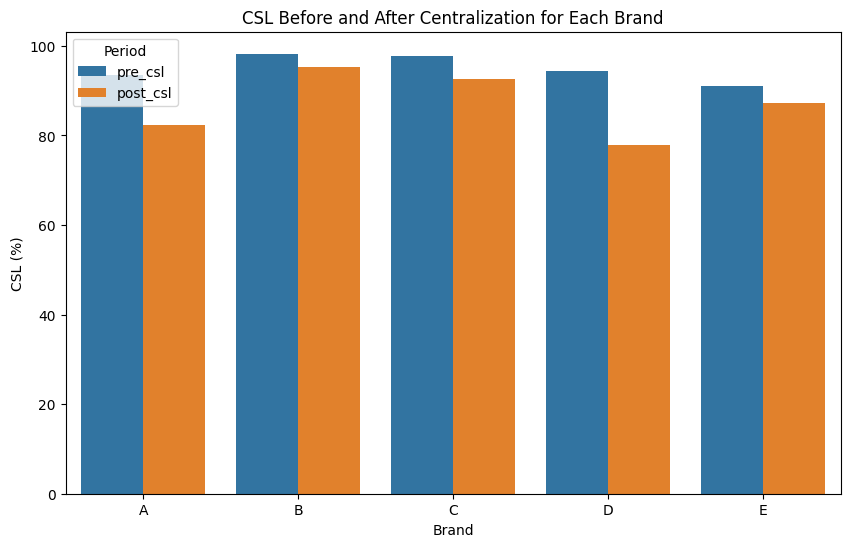

In [23]:
# Plotting the CSL results
plt.figure(figsize=(10, 6))
sns.barplot(data=csl_results_df.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable')
plt.title('CSL Before and After Centralization for Each Brand')
plt.xlabel('Brand')
plt.ylabel('CSL (%)')
plt.legend(title='Period')
plt.show()


In [24]:
def calculate_overall_csl(data, switch_date):
    switch_date = pd.to_datetime(switch_date)
    pre_period = data[(data['datetime'] < switch_date) & (data['datetime'] >= switch_date - pd.DateOffset(years=1))]
    post_period = data[(data['datetime'] >= switch_date) & (data['datetime'] < switch_date + pd.DateOffset(years=1))]
    
    pre_csl = (pre_period['boxes_delivered'].sum() / pre_period['boxes_ordered'].sum()) * 100
    post_csl = (post_period['boxes_delivered'].sum() / post_period['boxes_ordered'].sum()) * 100
    
    return pre_csl, post_csl

# Calculate overall CSL using the latest switching date as the reference
latest_switch_date = max(pd.to_datetime(list(switching_dates.values())))
overall_pre_csl, overall_post_csl = calculate_overall_csl(data, latest_switch_date)

overall_csl_results = {'Overall': {'pre_csl': overall_pre_csl, 'post_csl': overall_post_csl}}
overall_csl_results_df = pd.DataFrame(overall_csl_results).transpose()
overall_csl_results_df


,post_csl,pre_csl
Overall,90.381966,86.818096
